In [1]:
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *
from scoring import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=4, preprocess=True)

Loading files: ['../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'rachel', 'vinayak', 'vishnesh'}

Couldn't process grammar for annotation: ['positive', 'minor', '', '']


In [2]:
# Print spans with comments
get_comments(data)

RACHEL - HIT 5: When I try to annotate the split, the sentence freezes and no further edits are saved. 
Split-Positive Impact
Efficacy- A lot
No grammar error
And (before thenceforth) is part of the split edit.
Impact- none
No grammar error

RACHEL - HIT 14: "Between" would have been a good substitution, but not having the two events in chronological order makes the sentence more difficult to understand. 

RACHEL - HIT 15: Editing the split causes the sentence to freeze. 
Split
Negative Impact
Severity- Minor
No grammar error
"This was"- part of split edit
Trivial Insertion
No grammar error

VINAYAK - HIT 7: Should be a structure change for the substitution of "the arrival of" to "came into the area" and the reorder of "the storm". The structure change should have been a bad structure change, with a severity of "somewhat." 

VISHNESH - HIT 9: Was not sure how to annotate the missing comma which causes a grammatical error so I annotated it as an insertion for arrived.

VISHNESH - HIT 17

In [8]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [ ]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

In [ ]:
# Example: Annotations for sentence 0
data[0]['processed_annotations']

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.022727272727272728},
 {'edit_type': 'deletion',
  'id': 1,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.02727272727272727},
 {'edit_type': 'substitution',
  'id': 0,
  'information_impact': <Information.SAME: 'Same Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.031818181818181815},
 {'edit_type': 'substitution',
  'id': 1,
  'information_impact': <Information.SAME: 'Same Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 1,
  'size': 0.03636363636363636},
 {'edit_type': 'insertion',
  'id': 0,

In [ ]:
# Example: Edits for sentence 0
data[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': (130, 135),
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': (196, 202),
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'substitution',
  'id': 0,
  'original_span': (99, 110),
  'simplified_span': (99, 103),
  'annotation': ['same', 'positive', 'a lot', '', 'no']},
 {'type': 'substitution',
  'id': 1,
  'original_span': (123, 129),
  'simplified_span': (116, 130),
  'annotation': ['same', 'positive', 'somewhat', '', 'no']},
 {'type': 'insertion',
  'id': 0,
  'original_span': None,
  'simplified_span': (170, 173),
  'annotation': ['trivial', 'no', '', 'no']}]

In [ ]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [ ]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

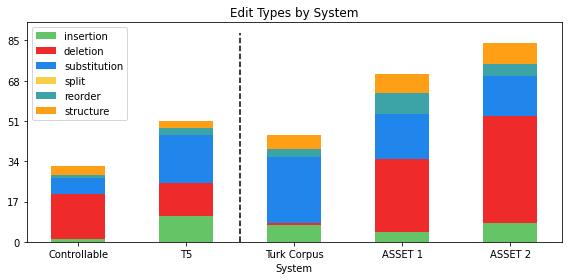

In [ ]:
edit_type_by_system(data, flipped=True)

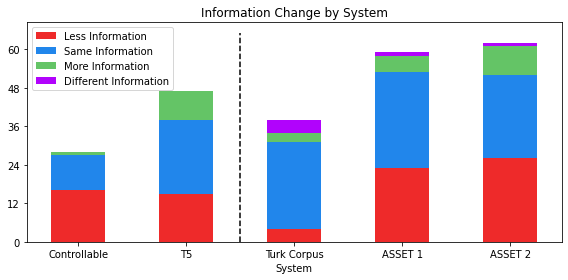

In [ ]:
system_by_information_change(data)

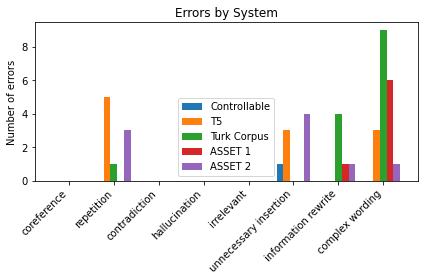

In [ ]:
errors_by_system(data)

In [ ]:
sankey_seperated(data)

In [ ]:
sankey_combined(data)

In [6]:
# Prints the sentences where annotators identified insertion errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(f'\n{error.value}')
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'HIT {sent["id"]+1} \t {sent["user"]} \t {system_name_mapping[sent["system"]]}')


Repetition
HIT 5 	 rachel 	 ASSET 2
HIT 7 	 rachel 	 T5
HIT 14 	 rachel 	 Turk Corpus
HIT 15 	 rachel 	 T5
HIT 5 	 vinayak 	 ASSET 2
HIT 15 	 vinayak 	 T5
HIT 15 	 vinayak 	 T5
HIT 5 	 vishnesh 	 ASSET 2
HIT 15 	 vishnesh 	 T5

Contradiction

Hallucination

Irrelevant


In [9]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

ASSET 1 	 8.66
Controllable 	 3.61
ASSET 2 	 9.6
Turk Corpus 	 5.15
T5 	 2.98


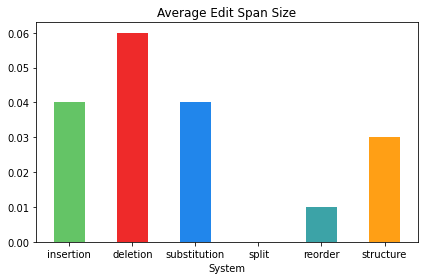

In [10]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

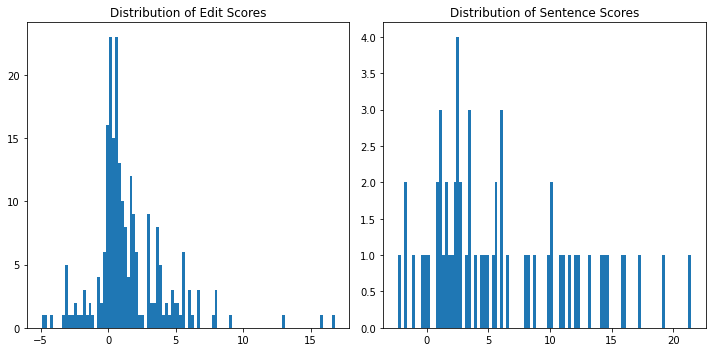

In [23]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [12]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vinayak - Batch 4, HIT 5 (ID 4) - 21.434458831105154
vinayak - Batch 4, HIT 13 (ID 12) - 19.16489917848816
vinayak - Batch 4, HIT 6 (ID 5) - 17.222046422441117
vinayak - Batch 4, HIT 10 (ID 9) - 16.173973191140128
vishnesh - Batch 4, HIT 5 (ID 4) - 15.878176622494912

Lowest scoring:
rachel - Batch 4, HIT 14 (ID 13) - -2.343307119355745
rachel - Batch 4, HIT 17 (ID 16) - -1.8555771393346832
rachel - Batch 4, HIT 18 (ID 17) - -1.7067372527931886
vishnesh - Batch 4, HIT 2 (ID 1) - -1.0549115382641698
rachel - Batch 4, HIT 6 (ID 5) - -0.31394460804584856


In [14]:
# Get setences with a score of 0
zero_scoring_sents(data)

[]

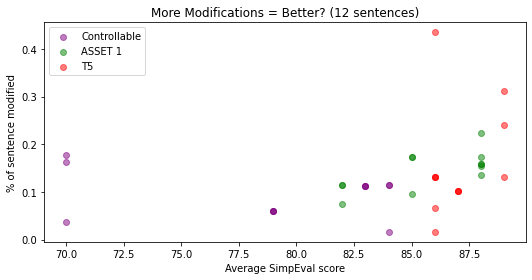

In [16]:
simp_eval_systems = [
    'systems/con_simplification.txt',
    'systems/asset.test.simp',
    'systems/T5.txt'
]
for system in simp_eval_systems:
    scores = [(int(sum(sent['simpeval_scores'])/5), sum([x['size'] for x in sent['processed_annotations']])) for sent in data if sent['system'] == system]
    pts = [p for p in scores if p[0] != 0]
    plt.scatter([p[0] for p in pts], [p[1] for p in pts], c =color_mapping[system], alpha=0.5, label=system_name_mapping[system])
plt.xlabel('Average SimpEval score')
plt.ylabel('% of sentence modified')
plt.title(f'More Modifications = Better? ({len(pts)} sentences)')
plt.legend()
plt.show()